# Cat Breeds Classification

## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Library

In [ ]:
%pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
# ==== Built-in Python Modules ====
import os
import sys
import shutil
import glob
import random
import json
import xml.etree.ElementTree as ET
from collections import defaultdict
from pathlib import Path
from IPython.display import Image, display

# ==== Data Manipulation & Analysis ====
import numpy as np
import pandas as pd

# ==== Visualization ====
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# ==== OpenCV ====
import cv2

# ==== Scikit-learn ====
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score
)

# ==== TensorFlow & Keras ====
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

# ==== TensorFlow.js ====
import tensorflowjs as tfjs

print("=== Modules Loaded ===")

=== Modules Loaded ===


## Data Loading

Dataset bersumber dari [Roboflow](https://universe.roboflow.com/petfriends/inu-dh) yang telah diunduh dan disimpan pada drive.


In [ ]:
# Path ke file zip
zip_file_path = '/content/drive/MyDrive/dicoding/capstone/inu-dh.v4i.voc.zip'

# Directory tempat ekstraksi konten
extract_dir = '/content/dataset'

# Buat direktori ekstraksi jika tidak ada
os.makedirs(extract_dir, exist_ok=True)

# Ekstrak file zip
shutil.unpack_archive(zip_file_path, extract_dir)

print(f"File extracted to: {extract_dir}")

File extracted to: /content/dataset


In [ ]:
# --- Konfigurasi ---
original_root = "dataset"
split_root = "dataset_split"
split_ratio = {"train": 0.8, "valid": 0.1, "test": 0.1}
seed = 42

# Mapping label serupa ke satu label utama
label_mapping = {
    "Scabies": "Scabies",
    "scabies": "Scabies",
    "deteksi scabies - v3 2024-07-29 3-22pm": "Scabies",
    "Jamur": "Jamur",
    "demodicosis": "Demodicosis",
    "dermatitis": "Dermatitis",
    "flea_allergy": "Flea_Allergy",
    "ringworm": "Ringworm",
}

def parse_voc_xml(xml_file):
    """
    Mengekstrak informasi dari satu file XML PASCAL VOC.
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Ambil info dasar gambar
    filename = root.find('filename').text
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    # Ekstrak semua objek (bounding box)
    objects = []
    for member in root.findall('object'):
        original_class_name = member.find('name').text
        # Normalisasi nama kelas menggunakan mapping
        normalized_class_name = label_mapping.get(original_class_name.strip(), original_class_name.strip())

        bndbox = member.find('bndbox')
        objects.append({
            'class': normalized_class_name,
            'xmin': int(bndbox.find('xmin').text),
            'ymin': int(bndbox.find('ymin').text),
            'xmax': int(bndbox.find('xmax').text),
            'ymax': int(bndbox.find('ymax').text),
        })

    return filename, width, height, objects

# --- Gabungkan semua data anotasi dari XML ---
print("--- Memulai Proses Penggabungan Anotasi dari XML ---")

# Hapus direktori lama jika ada untuk memulai dari awal
if os.path.exists(split_root):
    shutil.rmtree(split_root)

all_image_data = []
all_annotations_for_csv = []

for split_name in ["train", "valid", "test"]:
    split_dir = os.path.join(original_root, split_name)
    if not os.path.isdir(split_dir):
        print(f"Peringatan: Direktori '{split_dir}' tidak ditemukan, dilewati.")
        continue

    # Cari semua file .xml di direktori
    xml_files = glob.glob(os.path.join(split_dir, '*.xml'))
    print(f"\nMenemukan {len(xml_files)} file XML di '{split_dir}'")

    for xml_file in xml_files:
        try:
            filename, width, height, objects = parse_voc_xml(xml_file)
            image_path = os.path.join(split_dir, filename)

            # Pastikan file gambar yang sesuai ada
            if not os.path.exists(image_path):
                # Coba cari dengan ekstensi lain
                base, _ = os.path.splitext(image_path)
                found = False
                for ext in ['.jpg', '.jpeg', '.png']:
                    if os.path.exists(base + ext):
                        image_path = base + ext
                        filename = os.path.basename(image_path)
                        found = True
                        break
                if not found:
                    print(f"Peringatan: File gambar untuk '{filename}' tidak ditemukan. Anotasi dilewati.")
                    continue

            # Dapatkan semua kelas unik yang dinormalisasi untuk gambar ini
            unique_classes = sorted(list(set([obj['class'] for obj in objects])))

            image_record = {
                'original_path': image_path,
                'xml_path': xml_file,
                'filename': filename,
                'width': width,
                'height': height,
                'classes': unique_classes # Menyimpan daftar kelas
            }
            all_image_data.append(image_record)

            # Siapkan data untuk CSV anotasi final
            for obj in objects:
                all_annotations_for_csv.append({
                    'filename': filename,
                    'width': width,
                    'height': height,
                    'class': obj['class'],
                    'xmin': obj['xmin'],
                    'ymin': obj['ymin'],
                    'xmax': obj['xmax'],
                    'ymax': obj['ymax']
                })
        except Exception as e:
            print(f"Error memproses file {xml_file}: {e}")

print(f"\nTotal gambar yang ditemukan dan diproses: {len(all_image_data)}")

# --- Split data secara acak ---
print("\n--- Memulai Proses Pemisahan Data ---")
random.seed(seed)
random.shuffle(all_image_data)

total = len(all_image_data)
train_end = int(total * split_ratio["train"])
val_end = train_end + int(total * split_ratio["valid"])

splits = {
    "train": all_image_data[:train_end],
    "valid": all_image_data[train_end:val_end],
    "test": all_image_data[val_end:]
}

# --- Simpan ke struktur direktori baru ---
print("\n--- Menyimpan Hasil Pemisahan ke Folder ---")
final_counts = defaultdict(lambda: defaultdict(int))

for split_name, records in splits.items():
    split_dir_out = os.path.join(split_root, split_name)
    os.makedirs(split_dir_out, exist_ok=True)
    print(f"Memproses dan menyalin file untuk split: {split_name}...")

    for record in records:
        # Salin file gambar
        shutil.copy2(record['original_path'], os.path.join(split_dir_out, record['filename']))
        # Salin file XML
        xml_filename = os.path.basename(record['xml_path'])
        shutil.copy2(record['xml_path'], os.path.join(split_dir_out, xml_filename))

        # Hitung distribusi kelas
        for class_name in record['classes']:
            final_counts[split_name][class_name] += 1

# --- Buat file anotasi CSV gabungan ---
annotations_df = pd.DataFrame(all_annotations_for_csv)
# Pastikan urutan kolom sesuai untuk kemudahan pembacaan
annotations_df = annotations_df[['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']]
output_csv_path = os.path.join(split_root, "annotations.csv")
annotations_df.to_csv(output_csv_path, index=False)

print(f"\nFile anotasi gabungan berhasil disimpan di: {output_csv_path}")

print("\nSelesai! Ringkasan Hasil:")
print(f"Total gambar yang diproses: {total}")
for s in ["train", "valid", "test"]:
    print(f"-> {s.capitalize()}: {len(splits[s])} gambar")

print("\nDistribusi gambar per kelas di setiap split (sebuah gambar bisa masuk beberapa kelas):")
for split_name, counts in final_counts.items():
    print(f"\n--- {split_name.upper()} ---")
    sorted_counts = sorted(counts.items())
    for label, count in sorted_counts:
        print(f"  {label}: {count} gambar")

--- Memulai Proses Penggabungan Anotasi dari XML ---

Menemukan 4232 file XML di 'dataset/train'

Menemukan 1507 file XML di 'dataset/valid'

Menemukan 1506 file XML di 'dataset/test'

Total gambar yang ditemukan dan diproses: 7245

--- Memulai Proses Pemisahan Data ---

--- Menyimpan Hasil Pemisahan ke Folder ---
Memproses dan menyalin file untuk split: train...
Memproses dan menyalin file untuk split: valid...
Memproses dan menyalin file untuk split: test...

File anotasi gabungan berhasil disimpan di: dataset_split/annotations.csv

Selesai! Ringkasan Hasil:
Total gambar yang diproses: 7245
-> Train: 5796 gambar
-> Valid: 724 gambar
-> Test: 725 gambar

Distribusi gambar per kelas di setiap split (sebuah gambar bisa masuk beberapa kelas):

--- TRAIN ---
  Demodicosis: 965 gambar
  Dermatitis: 692 gambar
  Flea_Allergy: 473 gambar
  Jamur: 212 gambar
  Ringworm: 1240 gambar
  Scabies: 2227 gambar

--- VALID ---
  Demodicosis: 115 gambar
  Dermatitis: 85 gambar
  Flea_Allergy: 59 gamba

## Data Preparation

In [ ]:
# --- Konfigurasi ---
DATA_ROOT = "dataset_split"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VALID_DIR = os.path.join(DATA_ROOT, "valid")
TEST_DIR = os.path.join(DATA_ROOT, "test")
# File CSV yang berisi semua informasi bounding box
ANNOTATIONS_CSV = os.path.join(DATA_ROOT, "annotations.csv")
BEST_MODEL_PATH = "cat_disease.h5"

In [ ]:
# Parameter Model & Pelatihan
IMG_WIDTH, IMG_HEIGHT = 128, 128
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

In [ ]:
# --- Mempersiapkan Data ---
def load_and_prepare_dataframes(annotations_path, train_dir, valid_dir, test_dir):
    if not os.path.exists(annotations_path):
        print(f"KESALAHAN: File anotasi '{annotations_path}' tidak ditemukan.")
        sys.exit()

    master_df = pd.read_csv(annotations_path)

    # Mengambil file dari direktori
    train_files = {f for f in os.listdir(train_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))}
    valid_files = {f for f in os.listdir(valid_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))}
    test_files = {f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))}

    # Filter dataframe
    train_df = master_df[master_df['filename'].isin(train_files)].copy()
    valid_df = master_df[master_df['filename'].isin(valid_files)].copy()
    test_df = master_df[master_df['filename'].isin(test_files)].copy()

    # Membuat mapping kelas
    all_classes = sorted(master_df['class'].unique())
    class_to_int = {label: i for i, label in enumerate(all_classes)}

    # Proses semua dataframe dalam satu loop
    for df, dir_path in [(train_df, train_dir), (valid_df, valid_dir), (test_df, test_dir)]:
        if df.empty: continue
        df['filepath'] = df['filename'].apply(lambda f: os.path.join(dir_path, f))
        df['class_id'] = df['class'].map(class_to_int)
        df['xmin_norm'] = df['xmin'] / df['width']
        df['ymin_norm'] = df['ymin'] / df['height']
        df['xmax_norm'] = df['xmax'] / df['width']
        df['ymax_norm'] = df['ymax'] / df['height']

    return train_df, valid_df, test_df, class_to_int

In [ ]:
# Kelas untuk menghasilkan data generator untuk deteksi objek
class ObjectDetectionGenerator(tf.keras.utils.Sequence):
    # Inisialisasi generator
    def __init__(self, df, class_map, batch_size=32, target_size=(128, 128), shuffle=True):
        self.image_files = df['filename'].unique()          # Menyimpan nama file gambar yang unik
        self.df = df.set_index('filename')                  # Mengatur index dataframe berdasarkan nama file gambar
        self.class_map = class_map                          # Menyimpan mapping kelas
        self.num_classes = len(class_map)                   # Jumlah kelas
        self.batch_size = batch_size                        # Ukuran batch
        self.target_size = target_size                      # Ukuran target
        self.shuffle = shuffle                              # Apakah data diacak
        self.on_epoch_end()                                 # Memanggil fungsi on_epoch_end

    # Menghitung jumlah batch yang akan dihasilkan
    def __len__(self):
        return int(np.floor(len(self.image_files) / self.batch_size))

    # Mengambil item dari generator
    def __getitem__(self, index):
        batch_filenames = self.image_files[index*self.batch_size:(index+1)*self.batch_size]
        X, y_class, y_bbox = self.__data_generation(batch_filenames)
        return X, {'class_output': y_class, 'bbox_output': y_bbox}

    # Memanggil fungsi on_epoch_end
    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_files))
        if self.shuffle:
            np.random.shuffle(self.indices)
        self.image_files = self.image_files[self.indices]

    # Membuat data batch
    def __data_generation(self, batch_filenames):
        X = np.empty((self.batch_size, *self.target_size, 3))
        y_bbox = np.empty((self.batch_size, 4))
        y_class = np.empty((self.batch_size, self.num_classes))

        for i, filename in enumerate(batch_filenames):
            annotations = self.df.loc[filename]
            if isinstance(annotations, pd.DataFrame):
                annotation = annotations.iloc[0]
            else:
                annotation = annotations
            img_path = annotation['filepath']
            image = load_img(img_path, target_size=self.target_size)
            X[i,] = img_to_array(image) / 255.0
            y_bbox[i,] = [annotation['xmin_norm'], annotation['ymin_norm'], annotation['xmax_norm'], annotation['ymax_norm']]
            y_class[i,] = tf.keras.utils.to_categorical(annotation['class_id'], num_classes=self.num_classes)

        return X, y_class, y_bbox

In [ ]:
print("--- Memuat dan Mempersiapkan Dataset ---")
train_df, val_df, test_df, class_map = load_and_prepare_dataframes(ANNOTATIONS_CSV, TRAIN_DIR, VALID_DIR, TEST_DIR)
num_classes = len(class_map)

if train_df.empty or val_df.empty:
    print("KESALAHAN: Gagal memuat data latih atau validasi.")
    sys.exit()

print(f"\nKelas yang ditemukan: {class_map}")
print(f"Total data latih: {len(train_df['filename'].unique())} gambar")
print(f"Total data validasi: {len(val_df['filename'].unique())} gambar")
print(f"Total data tes: {len(test_df['filename'].unique())} gambar")

--- Memuat dan Mempersiapkan Dataset ---

Kelas yang ditemukan: {'Demodicosis': 0, 'Dermatitis': 1, 'Flea_Allergy': 2, 'Jamur': 3, 'Ringworm': 4, 'Scabies': 5}
Total data latih: 5796 gambar
Total data validasi: 724 gambar
Total data tes: 725 gambar


In [ ]:
# Path untuk file JSON
class_map_json_path = 'class_map.json'

# Simpan mapping ke file JSON
with open(class_map_json_path, 'w') as f:
    json.dump(class_map, f)

print(f"Mapping label disimpan di: {class_map_json_path}")

Mapping label disimpan di: class_map.json


## Modeling

In [ ]:
# Membangun Model
def create_object_detection_model(input_shape=(224, 224, 3), num_classes=2):

    # Base Model (Backbone)
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    # Input
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)

    # Head Model
    x = Flatten(name="flatten")(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)

    # Bounding Box Regression Head
    bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(x)

    # Classification Head
    class_output = Dense(num_classes, activation='softmax', name='class_output')(x)

    # Final Model
    model = Model(inputs=inputs, outputs=[class_output, bbox_output])
    return model

In [ ]:
train_generator = ObjectDetectionGenerator(train_df, class_map, batch_size=BATCH_SIZE)
val_generator = ObjectDetectionGenerator(val_df, class_map, batch_size=BATCH_SIZE, shuffle=False)

print("\n--- Membangun Model ---")
model = create_object_detection_model(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), num_classes=num_classes)

losses = {
    'class_output': 'categorical_crossentropy',
    'bbox_output': 'mean_squared_error'}

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss=losses, metrics={'class_output': 'accuracy'})
model.summary()

checkpoint = ModelCheckpoint(
    BEST_MODEL_PATH,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6,
    mode='min'
)

callbacks_list = [checkpoint, early_stopping, reduce_lr]


--- Membangun Model ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_1… │ (None, 4, 4,      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 20480)     │          0 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  2,621,568 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 6)         │        774 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │        516 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,880,842 (18.62 MB)

 Trainable params: 2,622,858 (10.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
print("\n--- Memulai Pelatihan Model ---")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks_list
)
print(f"\nModel terbaik telah disimpan di '{BEST_MODEL_PATH}'.")


--- Memulai Pelatihan Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - bbox_output_loss: 0.1425 - class_output_accuracy: 0.5883 - class_output_loss: 1.6761 - loss: 1.8187
Epoch 1: val_loss improved from inf to 0.89716, saving model to cat_disease.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 36s 140ms/step - bbox_output_loss: 0.1424 - class_output_accuracy: 0.5886 - class_output_loss: 1.6732 - loss: 1.8156 - val_bbox_output_loss: 0.0749 - val_class_output_accuracy: 0.7060 - val_class_output_loss: 0.8222 - val_loss: 0.8972 - learning_rate: 0.0010
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - bbox_output_loss: 0.0819 - class_output_accuracy: 0.6948 - class_output_loss: 0.8443 - loss: 0.9262
Epoch 2: val_loss improved from 0.89716 to 0.67574, saving model to cat_disease.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - bbox_output_loss: 0.0818 - class_output_accuracy: 0.6949 - class_output_loss: 0.8440 - loss: 0.9258 - val_bbox_output_loss: 0.0560 - val_class_output_accuracy: 0.8040 - val_class_output_loss: 0.6198 - val_loss: 0.6757 - learning_rate: 0.0010
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - bbox_output_loss: 0.0526 - class_output_accuracy: 0.7259 - class_output_loss: 0.7062 - loss: 0.7588
Epoch 3: val_loss improved from 0.67574 to 0.64707, saving model to cat_disease.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - bbox_output_loss: 0.0526 - class_output_accuracy: 0.7259 - class_output_loss: 0.7061 - loss: 0.7587 - val_bbox_output_loss: 0.0376 - val_class_output_accuracy: 0.7997 - val_class_output_loss: 0.6095 - val_loss: 0.6471 - learning_rate: 0.0010
Epoch 4/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - bbox_output_loss: 0.0407 - class_output_accuracy: 0.7575 - class_output_loss: 0.6222 - loss: 0.6629
Epoch 4: val_loss improved from 0.64707 to 0.59658, saving model to cat_disease.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - bbox_output_loss: 0.0407 - class_output_accuracy: 0.7575 - class_output_loss: 0.6222 - loss: 0.6629 - val_bbox_output_loss: 0.0372 - val_class_output_accuracy: 0.8054 - val_class_output_loss: 0.5594 - val_loss: 0.5966 - learning_rate: 0.0010
Epoch 5/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - bbox_output_loss: 0.0385 - class_output_accuracy: 0.7782 - class_output_loss: 0.5542 - loss: 0.5927
Epoch 5: val_loss did not improve from 0.59658
181/181 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - bbox_output_loss: 0.0385 - class_output_accuracy: 0.7782 - class_output_loss: 0.5542 - loss: 0.5927 - val_bbox_output_loss: 0.0342 - val_class_output_accuracy: 0.8153 - val_class_output_loss: 0.6696 - val_loss: 0.7038 - learning_rate: 0.0010
Epoch 6/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - bbox_output_loss: 0.0364 - class_output_accuracy: 0.7970 - class_output_loss: 0.5061 - loss: 0.5425
Epoch 6: val_loss did not improve from 0.59658
181/181 ━━━━━━━━━━━

181/181 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - bbox_output_loss: 0.0354 - class_output_accuracy: 0.8117 - class_output_loss: 0.4788 - loss: 0.5141 - val_bbox_output_loss: 0.0336 - val_class_output_accuracy: 0.8281 - val_class_output_loss: 0.5278 - val_loss: 0.5614 - learning_rate: 0.0010
Epoch 8/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - bbox_output_loss: 0.0352 - class_output_accuracy: 0.8121 - class_output_loss: 0.4439 - loss: 0.4791
Epoch 8: val_loss improved from 0.56139 to 0.52915, saving model to cat_disease.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 25s 140ms/step - bbox_output_loss: 0.0352 - class_output_accuracy: 0.8122 - class_output_loss: 0.4439 - loss: 0.4790 - val_bbox_output_loss: 0.0329 - val_class_output_accuracy: 0.8509 - val_class_output_loss: 0.4962 - val_loss: 0.5291 - learning_rate: 0.0010
Epoch 9/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - bbox_output_loss: 0.0347 - class_output_accuracy: 0.8350 - class_output_loss: 0.3977 - loss: 0.4324
Epoch 9: val_loss did not improve from 0.52915
181/181 ━━━━━━━━━━━━━━━━━━━━ 40s 132ms/step - bbox_output_loss: 0.0347 - class_output_accuracy: 0.8350 - class_output_loss: 0.3977 - loss: 0.4325 - val_bbox_output_loss: 0.0331 - val_class_output_accuracy: 0.8594 - val_class_output_loss: 0.5285 - val_loss: 0.5616 - learning_rate: 0.0010
Epoch 10/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - bbox_output_loss: 0.0349 - class_output_accuracy: 0.8347 - class_output_loss: 0.3860 - loss: 0.4209
Epoch 10: val_loss improved from 0.52915 to 0.47997, saving mode

181/181 ━━━━━━━━━━━━━━━━━━━━ 38s 116ms/step - bbox_output_loss: 0.0349 - class_output_accuracy: 0.8347 - class_output_loss: 0.3860 - loss: 0.4209 - val_bbox_output_loss: 0.0331 - val_class_output_accuracy: 0.8565 - val_class_output_loss: 0.4468 - val_loss: 0.4800 - learning_rate: 0.0010
Epoch 11/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - bbox_output_loss: 0.0344 - class_output_accuracy: 0.8450 - class_output_loss: 0.3684 - loss: 0.4028
Epoch 11: val_loss did not improve from 0.47997
181/181 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - bbox_output_loss: 0.0345 - class_output_accuracy: 0.8450 - class_output_loss: 0.3684 - loss: 0.4029 - val_bbox_output_loss: 0.0332 - val_class_output_accuracy: 0.8565 - val_class_output_loss: 0.4918 - val_loss: 0.5250 - learning_rate: 0.0010
Epoch 12/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - bbox_output_loss: 0.0348 - class_output_accuracy: 0.8412 - class_output_loss: 0.3617 - loss: 0.3965
Epoch 12: val_loss did not improve from 0.47997
181/181 ━━━━━━

In [ ]:
# Save as TensorFlow SavedModel format
saved_model_dir = 'cat_disease_savedmodel'
model.export(saved_model_dir)
print(f"Model saved in SavedModel format at: {saved_model_dir}")

# Save as TensorFlow.js format
tfjs_model_dir = 'cat_disease_tfjs'
tfjs.converters.save_keras_model(model, tfjs_model_dir)
print(f"Model saved in TensorFlow.js format at: {tfjs_model_dir}")

Saved artifact at 'cat_disease_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  List[TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)]
Captures:
  140193370046928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140193370054224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140193370051152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140193370052688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140193370047120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140193370050384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140193371121680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140193371127248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140193370054992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1401933700

Model saved in SavedModel format at: cat_disease_savedmodel
failed to lookup keras version from the file,
    this is likely a weight only file
Model saved in TensorFlow.js format at: cat_disease_tfjs


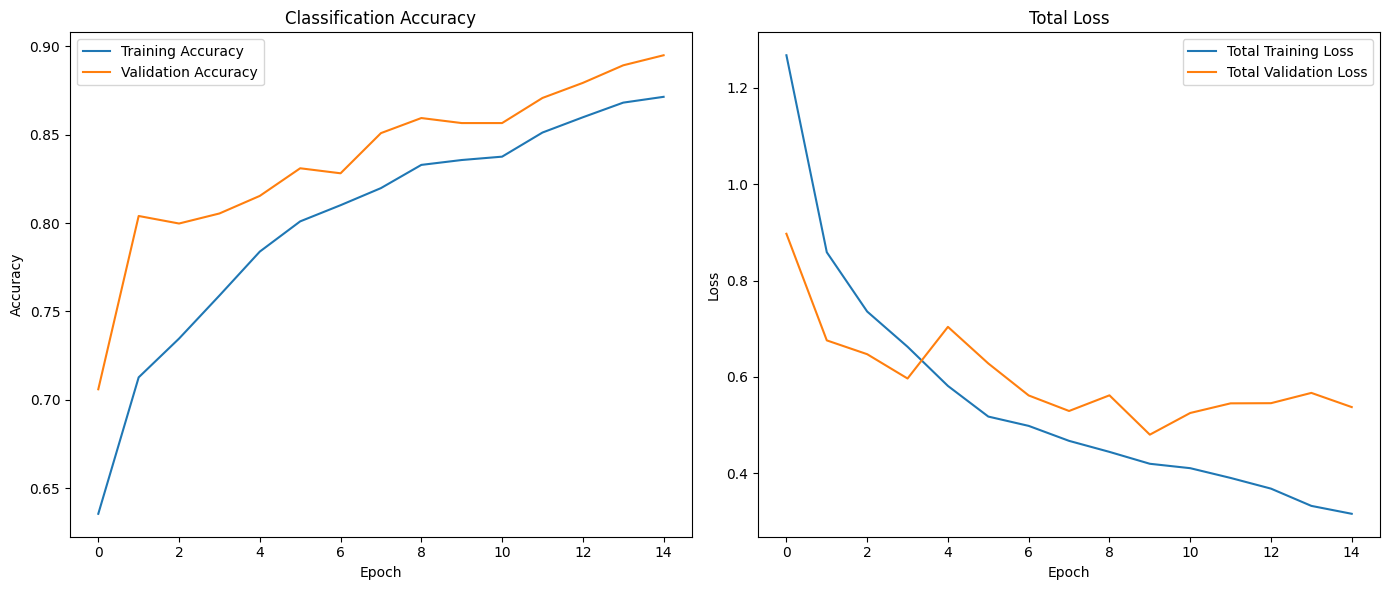

In [ ]:
# Visualisasi Hasil Pelatihan
def plot_history(history):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['class_output_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_class_output_accuracy'], label='Validation Accuracy')
    plt.title('Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Total Training Loss')
    plt.plot(history.history['val_loss'], label='Total Validation Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)

In [ ]:
# Evaluasi Model pada Data Tes
def evaluate_on_test_data(model_path, test_df, class_map):
    if test_df.empty:
        print("\nTidak ada data tes untuk dievaluasi. Melewatkan langkah ini.")
        return

    print("\n--- Mengevaluasi Model pada Data Tes ---")

    # Buat generator untuk data tes
    test_generator = ObjectDetectionGenerator(test_df, class_map, batch_size=BATCH_SIZE, shuffle=False)

    # Muat model terbaik
    best_model = tf.keras.models.load_model(model_path)

    # Buat prediksi pada data tes
    predictions = best_model.predict(test_generator, verbose=1)
    pred_classes_probs = predictions[0]

    # Dapatkan label prediksi (kelas dengan probabilitas tertinggi)
    y_pred = np.argmax(pred_classes_probs, axis=1)

    # Dapatkan label sebenarnya (true labels)
    # Karena shuffle=False, urutannya cocok dengan image_files di generator
    true_df = test_df.drop_duplicates(subset='filename').set_index('filename')
    y_true = true_df.loc[test_generator.image_files]['class_id'].values[:len(y_pred)]

    class_labels = list(class_map.keys())
    # Tampilkan Classification Report
    print("\nLaporan Klasifikasi (Classification Report):")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Tampilkan Confusion Matrix
    print("\nMatriks Konfusi (Confusion Matrix):")
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('Kelas Aktual (True Label)')
    plt.xlabel('Kelas Prediksi (Predicted Label)')
    plt.show()


--- Mengevaluasi Model pada Data Tes ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step

Laporan Klasifikasi (Classification Report):
              precision    recall  f1-score   support

 Demodicosis       0.99      0.98      0.99       101
  Dermatitis       0.93      0.70      0.80       109
Flea_Allergy       0.76      0.81      0.78        58
       Jamur       0.67      0.23      0.34        26
    Ringworm       0.80      0.96      0.87       141
     Scabies       0.90      0.95      0.93       269

    accuracy                           0.88       704
   macro avg       0.84      0.77      0.78       704
weighted avg       0.88      0.88      0.87       704


Matriks Konfusi (Confusion Matrix):


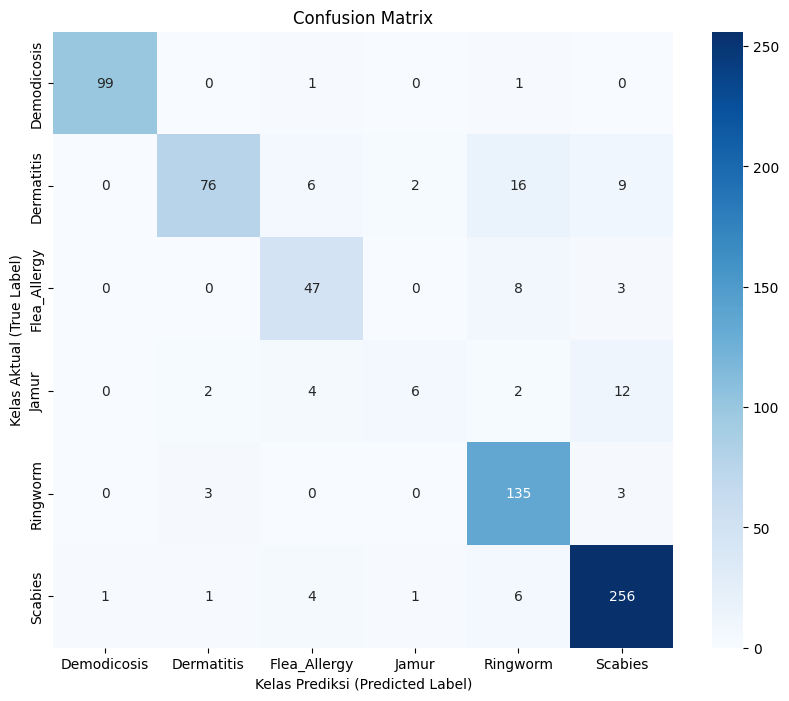

In [ ]:
# Jalankan evaluasi
evaluate_on_test_data(BEST_MODEL_PATH, test_df, class_map)


--- Menjalankan Prediksi pada Gambar Contoh: dataset_split/test/IMG_5195_jpeg_jpg.rf.eaf11cc399ff1f39702f200f9cd085ef.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


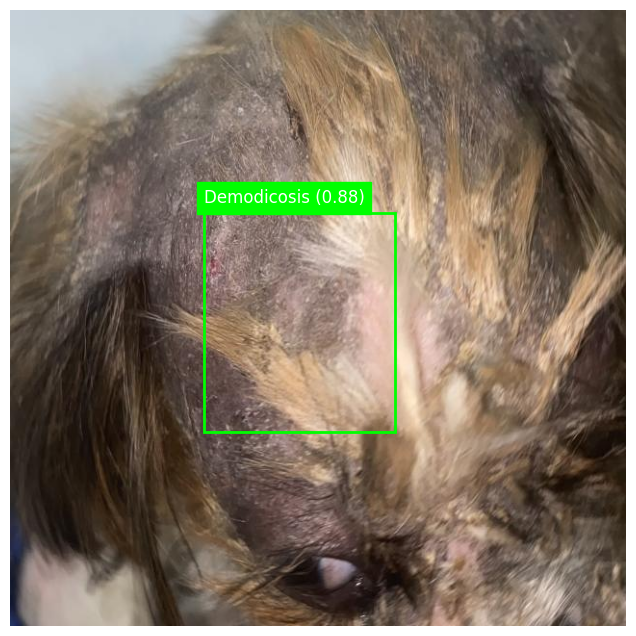

In [ ]:
# Visualisasi Prediksi tunggal (sebagai contoh)
def predict_and_visualize(model_path, image_path, class_map):
    print(f"\n--- Menjalankan Prediksi pada Gambar Contoh: {image_path} ---")
    model = tf.keras.models.load_model(model_path, compile=False)
    image = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    image_array = img_to_array(image) / 255.0
    image_batch = np.expand_dims(image_array, axis=0)
    pred_class, pred_bbox = model.predict(image_batch)
    class_id = np.argmax(pred_class[0])
    int_to_class = {v: k for k, v in class_map.items()}
    class_label = int_to_class[class_id]
    confidence = pred_class[0][class_id]
    xmin, ymin, xmax, ymax = pred_bbox[0]
    original_image = np.array(load_img(image_path))
    h, w, _ = original_image.shape
    xmin_abs, ymin_abs, xmax_abs, ymax_abs = int(xmin * w), int(ymin * h), int(xmax * w), int(ymax * h)

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(original_image)
    rect = patches.Rectangle((xmin_abs, ymin_abs), xmax_abs - xmin_abs, ymax_abs - ymin_abs, linewidth=2, edgecolor='lime', facecolor='none')
    ax.add_patch(rect)
    plt.text(xmin_abs, ymin_abs - 10, f'{class_label} ({confidence:.2f})', color='white', backgroundcolor='lime', fontsize=12)
    plt.axis('off')
    plt.show()

if not test_df.empty:
    sample_image_path = test_df.iloc[np.random.randint(0, len(test_df))]['filepath']
    predict_and_visualize(BEST_MODEL_PATH, sample_image_path, class_map)

## Inference

[INFO] Class map berhasil dimuat dari /content/class_map.json
[INFO] Mapped classes: {0: 'Demodicosis', 1: 'Dermatitis', 2: 'Flea_Allergy', 3: 'Jamur', 4: 'Ringworm', 5: 'Scabies'}

[INFO] Memuat model...
[INFO] Model berhasil dimuat.

[INFO] Memproses satu gambar: /content/inference-3.jpg
--> Memproses: inference-3.jpg
    Prediksi: Ringworm: 95.35%


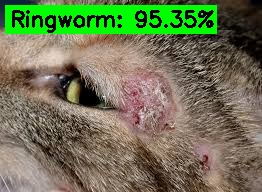


[INFO] Proses inference selesai.


In [ ]:
# --- Konfigurasi ---
IMG_WIDTH, IMG_HEIGHT = 128, 128
CLASS_MAP_JSON = '/content/class_map.json' # Path ke file JSON
CLASS_MAP = {} # Akan diisi dari file JSON

# Load class map from JSON
try:
    with open(CLASS_MAP_JSON, 'r') as f:
        loaded_class_map = json.load(f)
        # Ubah key string menjadi integer
        CLASS_MAP = {v: k for k, v in loaded_class_map.items()}
    print(f"[INFO] Class map berhasil dimuat dari {CLASS_MAP_JSON}")
    print(f"[INFO] Mapped classes: {CLASS_MAP}")
except FileNotFoundError:
    print(f"Error: File class map '{CLASS_MAP_JSON}' tidak ditemukan.")
    print("Pastikan Anda telah menjalankan sel yang membuat file class_map.json.")
    sys.exit()
except json.JSONDecodeError:
    print(f"Error: Gagal membaca file JSON '{CLASS_MAP_JSON}'. Pastikan formatnya benar.")
    sys.exit()


def predict_on_image(model, image_path, output_dir, confidence_threshold=0.5):
    print(f"--> Memproses: {os.path.basename(image_path)}")

    # Load gambar asli
    original_image = cv2.imread(image_path)
    if original_image is None:
        print(f"    Peringatan: Gagal memuat gambar {image_path}, dilewati.")
        return

    # Resize & normalisasi untuk model
    image_for_model = cv2.resize(original_image, (IMG_WIDTH, IMG_HEIGHT))
    image_for_model = image_for_model.astype("float32") / 255.0
    image_batch = np.expand_dims(image_for_model, axis=0)

    # Prediksi model
    pred_class_probs, _ = model.predict(image_batch, verbose=0) # Set verbose=0 untuk output yang lebih bersih saat batch processing
    class_id = np.argmax(pred_class_probs[0])
    confidence = pred_class_probs[0][class_id]

    if confidence < confidence_threshold:
        print(f"    Info: Prediksi di bawah threshold ({confidence:.2f} < {confidence_threshold}). Label tidak ditambahkan.")
        label_text = "No confident prediction"
    else:
        # Ambil label dari CLASS_MAP
        class_label = CLASS_MAP.get(class_id, "Unknown")
        label_text = f"{class_label}: {confidence:.2%}"  # Persentase

    # Tambahkan label ke gambar
    labeled_image = original_image.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    color = (0, 255, 0)
    thickness = 2
    (text_width, text_height), baseline = cv2.getTextSize(label_text, font, font_scale, thickness)
    # Tambahkan teks hasil prediksi ke gambar
    cv2.rectangle(labeled_image, (5, 5), (10 + text_width, 10 + text_height + baseline), (0, 255, 0), -1)
    cv2.putText(labeled_image, label_text, (10, 10 + text_height), font, font_scale, (0, 0, 0), thickness)

    # Simpan atau tampilkan
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, "pred_" + os.path.basename(image_path))
        cv2.imwrite(output_path, labeled_image)
        print(f"    Hasil disimpan di: {output_path}")
    else:
        print(f"    Prediksi: {label_text}")
        # Untuk menampilkan
        temp_output_path = "/tmp/temp_pred_" + os.path.basename(image_path)
        cv2.imwrite(temp_output_path, labeled_image)
        display(Image(filename=temp_output_path))


def run_inference(model_path, input_path, output_dir=None, threshold=0.5):
    if not os.path.exists(model_path):
        print(f"Error: File model tidak ditemukan di '{model_path}'")
        return

    if not os.path.exists(input_path):
        print(f"Error: Path input tidak ditemukan di '{input_path}'")
        return

    print("\n[INFO] Memuat model...")
    try:
        # Pastikan model dimuat tanpa kompilasi karena hanya untuk inference
        model = tf.keras.models.load_model(model_path, compile=False)
        print("[INFO] Model berhasil dimuat.")
    except Exception as e:
        print(f"Error: Gagal memuat model. Kesalahan: {e}")
        return

    if os.path.isdir(input_path):
        print(f"\n[INFO] Memproses semua gambar di direktori: {input_path}")
        image_files = [f for f in os.listdir(input_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if not image_files:
            print("Error: Tidak ada file gambar yang ditemukan di direktori input.")
            return

        for image_file in image_files:
            full_image_path = os.path.join(input_path, image_file)
            predict_on_image(model, full_image_path, output_dir, threshold)

    elif os.path.isfile(input_path):
        print(f"\n[INFO] Memproses satu gambar: {input_path}")
        predict_on_image(model, input_path, output_dir, threshold)

    print("\n[INFO] Proses inference selesai.")


# --- Penggunaan ---
if __name__ == "__main__":
    # Path model
    MODEL_PATH_INPUT = "/content/cat_disease.h5"

    # Path gambar atau direktori gambar yang ingin diuji
    INPUT_PATH_INPUT = "/content/inference-3.jpg" # Contoh path gambar
    # INPUT_PATH_INPUT = "/content/dataset_split/test" # Contoh path direktori

    # Uncomment baris di bawah ini jika ingin menyimpan hasil prediksi ke direktori
    # OUTPUT_PATH_DIR = "/content/hasil_prediksi_inference"

    # Ambang batas kepercayaan (confidence threshold) untuk menampilkan label
    CONFIDENCE_THRESHOLD_INPUT = 0.5

    run_inference(
        model_path=MODEL_PATH_INPUT,
        input_path=INPUT_PATH_INPUT,
        # output_dir=OUTPUT_PATH_DIR, # Uncomment untuk menyimpan hasil
        threshold=CONFIDENCE_THRESHOLD_INPUT
    )

## Kompres dan Download Model

In [ ]:
%pip install pipreqs

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.1 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=6242751692c09babbad2f5a190845f613bdab9bb241e58e44d3b57494e795951
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt
  Attempting uninstall: ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.12.3 which is incompatible.


In [ ]:
!pipreqs ./ --scan-notebooks --force

Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.


In [ ]:
!zip -r cat_disease_savedmodel.zip cat_disease_savedmodel
!zip -r cat_disease_tfjs.zip cat_disease_tfjs

  adding: cat_disease_savedmodel/ (stored 0%)
  adding: cat_disease_savedmodel/fingerprint.pb (stored 0%)
  adding: cat_disease_savedmodel/assets/ (stored 0%)
  adding: cat_disease_savedmodel/variables/ (stored 0%)
  adding: cat_disease_savedmodel/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: cat_disease_savedmodel/variables/variables.index (deflated 78%)
  adding: cat_disease_savedmodel/saved_model.pb (deflated 91%)
  adding: cat_disease_tfjs/ (stored 0%)
  adding: cat_disease_tfjs/group1-shard1of5.bin (deflated 7%)
  adding: cat_disease_tfjs/group1-shard5of5.bin (deflated 7%)
  adding: cat_disease_tfjs/group1-shard2of5.bin (deflated 7%)
  adding: cat_disease_tfjs/model.json (deflated 97%)
  adding: cat_disease_tfjs/group1-shard3of5.bin (deflated 7%)
  adding: cat_disease_tfjs/group1-shard4of5.bin (deflated 7%)


In [ ]:
from google.colab import files
files.download('cat_disease_savedmodel.zip')
files.download('cat_disease_tfjs.zip')
files.download('cat_disease.h5')
files.download('class_map.json')
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>